In [ ]:
!pip3 install transformers
!pip3 install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 57.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 102.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.2 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers[sentencepiece] datasets sacrebleu rouge_score py7zr -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 13.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 66.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 57.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.3/399.3 kB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.8/138.8 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 5.2 MB/s eta 0:0

In [ ]:
from transformers import pipeline

import matplotlib.pyplot as plt

import pandas as pd
#from datasets import load_dataset
from datasets import load_metric

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

import nltk
from nltk.tokenize import sent_tokenize

from tqdm import tqdm
import torch

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [ ]:
from datasets import load_dataset

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_checkpoint = 'google/pegasus-multi_news'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model_pegasus = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint).to(device)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
device
print(torch.cuda.memory_allocated())

0


In [ ]:
dataset_cnn = load_dataset('cnn_dailymail','3.0.0')
split_lengths = [len(dataset_cnn[split])for split in dataset_cnn]

print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_cnn['train'].column_names}")

  0%|          | 0/3 [00:00<?, ?it/s]

Split lengths: [287113, 13368, 11490]
Features: ['article', 'highlights', 'id']


In [ ]:
dataset_cnn

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

In [ ]:
#Evaluating the pretrained pegasus xsum on cnn dailymail dataset before training

In [ ]:
def generate_batch_sized_chunks(list_of_elements, batch_size):
    """split the dataset into smaller batches that we can process simultaneously
    Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]


In [ ]:
def calculate_metric_on_test_ds(dataset, metric, model, tokenizer, 
                               batch_size=8, device=device, 
                               column_text="article", 
                               column_summary="highlights"):
    article_batches = list(generate_batch_sized_chunks(dataset[column_text], batch_size))
    target_batches = list(generate_batch_sized_chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):
        
        inputs = tokenizer(article_batch, max_length=1024,  truncation=True, 
                        padding="max_length", return_tensors="pt")
        
        # Filter out examples with a shorter sequence length
        #mask = inputs['attention_mask'].sum(dim=1) > 0
        #inputs = {k: v[mask] for k, v in inputs.items()}
        #target_batch = [t for t, m in zip(target_batch, mask) if m]
        
        print("input_ids shape:", inputs["input_ids"].shape)
        print("max input_ids value:", inputs["input_ids"].max())
        print("vocabulary size:", tokenizer.vocab_size)

        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device), 
                         length_penalty=0.8, num_beams=8, max_length=128)
        ''' parameter for length penalty ensures that the model does not generate sequences that are too long. '''
       
        print(summaries.shape)
        print(inputs["attention_mask"].shape)
        # Finally, we decode the generated texts, 
        # replace the <n> token, and add the decoded texts with the references to the metric.
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, 
                                clean_up_tokenization_spaces=True) 
               for s in summaries]      
        
        #decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]
        
        
        metric.add_batch(predictions=decoded_summaries, references=target_batch)
        
    #  Finally compute and return the ROUGE scores.
    score = metric.compute(use_stemmer=False)
    return score

In [ ]:
pipe = pipeline('summarization', model=model_checkpoint)
pipe_out = pipe(dataset_cnn['test'][10]['article'])
print(pipe_out)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/pipelines/__init__.py:788 in pipeline       │
│                                                                                                  │
│   785 │   # Forced if framework already defined, inferred if it's None                           │
│   786 │   # Will load the correct model if possible                                              │
│   787 │   model_classes = {"tf": targeted_task["tf"], "pt": targeted_task["pt"]}                 │
│ ❱ 788 │   framework, model = infer_framework_load_model(                                         │
│   789 │   │   model,                                                                             │
│   790 │   │   model_classes=model_classes,                                                       │
│   791 │   │   config=config,                                                                     │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:270 in                    │
│ infer_framework_load_model                                                                       │
│                                                                                                  │
│    267 │   │   │   │   )                                                                         │
│    268 │   │   │                                                                                 │
│    269 │   │   │   try:                                                                          │
│ ❱  270 │   │   │   │   model = model_class.from_pretrained(model, **kwargs)                      │
│    271 │   │   │   │   if hasattr(model, "eval"):                                                │
│    272 │   │   │   │   │   model = model.eval()                                                  │
│    273 │   │   │   │   # Stop loading on the first successful load.                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/models/auto/auto_factory.py:467 in          │
│ from_pretrained                                                                                  │
│                                                                                                  │
│   464 │   │   │   )                                                                              │
│   465 │   │   elif type(config) in cls._model_mapping.keys():                                    │
│   466 │   │   │   model_class = _get_model_class(config, cls._model_mapping)                     │
│ ❱ 467 │   │   │   return model_class.from_pretrained(                                            │
│   468 │   │   │   │   pretrained_model_name_or_path, *model_args, config=config, **hub_kwargs,   │
│   469 │   │   │   )                                                                              │
│   470 │   │   raise ValueError(                                                                  │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2611 in from_pretrained   │
│                                                                                                  │
│   2608 │   │   │   init_contexts.append(init_empty_weights())                                    │
│   2609 │   │                                                                                     │
│   2610 │   │   with ContextManagers(init_contexts):        

In [ ]:
print('*****article**********')
print(dataset_cnn['test'][10]['article'])

*****article**********
London (CNN)A 19-year-old man was charged Wednesday with terror offenses after he was arrested as he returned to Britain from Turkey, London's Metropolitan Police said. Yahya Rashid, a UK national from northwest London, was detained at Luton airport on Tuesday after he arrived on a flight from Istanbul, police said. He's been charged with engaging in conduct in preparation of acts of terrorism, and with engaging in conduct with the intention of assisting others to commit acts of terrorism. Both charges relate to the period between November 1 and March 31. Rashid is due to appear in Westminster Magistrates' Court on Wednesday, police said. CNN's Lindsay Isaac contributed to this report.


In [ ]:
print('*********human generated reference summary*********')
print(dataset_cnn['test'][10]['highlights'])

*********human generated reference summary*********
London's Metropolitan Police say the man was arrested at Luton airport after landing on a flight from Istanbul .
He's been charged with terror offenses allegedly committed since the start of November .


In [ ]:
import torch
torch.cuda.empty_cache()


In [ ]:
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

rouge_metric = load_metric('rouge')

score = calculate_metric_on_test_ds(dataset_cnn['test'][:1000], rouge_metric, model_pegasus, tokenizer, column_text = 'article', column_summary='highlights', batch_size=8 )

  0%|          | 0/125 [00:00<?, ?it/s]

input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95967)
vocabulary size: 96103
torch.Size([8, 128])
torch.Size([8, 1024])


  1%|          | 1/125 [01:20<2:46:11, 80.42s/it]

input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(88699)
vocabulary size: 96103


  2%|▏         | 2/125 [02:36<2:40:03, 78.08s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(94811)
vocabulary size: 96103


  2%|▏         | 3/125 [03:53<2:37:08, 77.29s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95607)
vocabulary size: 96103


  3%|▎         | 4/125 [05:10<2:35:41, 77.20s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95013)
vocabulary size: 96103


  4%|▍         | 5/125 [06:26<2:33:44, 76.87s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95460)
vocabulary size: 96103


  5%|▍         | 6/125 [07:42<2:31:40, 76.47s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(93338)
vocabulary size: 96103


  6%|▌         | 7/125 [08:58<2:30:07, 76.34s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95379)
vocabulary size: 96103


  6%|▋         | 8/125 [10:14<2:28:44, 76.28s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95775)
vocabulary size: 96103


  7%|▋         | 9/125 [11:44<2:35:52, 80.62s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(94872)
vocabulary size: 96103


  8%|▊         | 10/125 [12:56<2:29:36, 78.06s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95616)
vocabulary size: 96103


  9%|▉         | 11/125 [14:13<2:27:14, 77.50s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95659)
vocabulary size: 96103


 10%|▉         | 12/125 [15:29<2:25:02, 77.02s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(94712)
vocabulary size: 96103


 10%|█         | 13/125 [16:46<2:23:49, 77.05s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95642)
vocabulary size: 96103
torch.Size([8, 128])
torch.Size([8, 1024])


 11%|█         | 14/125 [17:56<2:18:57, 75.12s/it]

input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(92719)
vocabulary size: 96103


 12%|█▏        | 15/125 [19:11<2:17:38, 75.08s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(94429)
vocabulary size: 96103


 13%|█▎        | 16/125 [20:25<2:15:40, 74.68s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95386)
vocabulary size: 96103


 14%|█▎        | 17/125 [21:36<2:12:20, 73.53s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(93338)
vocabulary size: 96103


 14%|█▍        | 18/125 [22:49<2:10:39, 73.27s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(94815)
vocabulary size: 96103
torch.Size([8, 128])
torch.Size([8, 1024])


 15%|█▌        | 19/125 [23:59<2:07:39, 72.26s/it]

input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95775)
vocabulary size: 96103


 16%|█▌        | 20/125 [25:14<2:08:03, 73.17s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95134)
vocabulary size: 96103


 17%|█▋        | 21/125 [26:28<2:07:33, 73.59s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(93872)
vocabulary size: 96103


 18%|█▊        | 22/125 [27:32<2:01:09, 70.58s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95134)
vocabulary size: 96103


 18%|█▊        | 23/125 [28:25<1:50:49, 65.19s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(90254)
vocabulary size: 96103


 19%|█▉        | 24/125 [29:17<1:43:14, 61.33s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(93615)
vocabulary size: 96103


 20%|██        | 25/125 [30:07<1:36:40, 58.01s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95693)
vocabulary size: 96103


 21%|██        | 26/125 [31:00<1:33:00, 56.37s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(93301)
vocabulary size: 96103


 22%|██▏       | 27/125 [31:48<1:28:07, 53.95s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95452)
vocabulary size: 96103


 22%|██▏       | 28/125 [32:40<1:26:20, 53.40s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(93003)
vocabulary size: 96103


 23%|██▎       | 29/125 [33:28<1:22:40, 51.67s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95608)
vocabulary size: 96103


 24%|██▍       | 30/125 [34:15<1:19:53, 50.46s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95720)
vocabulary size: 96103


 25%|██▍       | 31/125 [35:03<1:17:43, 49.61s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95921)
vocabulary size: 96103


 26%|██▌       | 32/125 [35:55<1:18:05, 50.38s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95987)
vocabulary size: 96103


 26%|██▋       | 33/125 [36:47<1:18:05, 50.93s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(92819)
vocabulary size: 96103


 27%|██▋       | 34/125 [37:40<1:17:46, 51.28s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(96092)
vocabulary size: 96103


 28%|██▊       | 35/125 [38:27<1:15:08, 50.09s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(93566)
vocabulary size: 96103


 29%|██▉       | 36/125 [39:18<1:14:45, 50.40s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(94961)
vocabulary size: 96103


 30%|██▉       | 37/125 [40:05<1:12:16, 49.28s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(94726)
vocabulary size: 96103
torch.Size([8, 128])
torch.Size([8, 1024])


 30%|███       | 38/125 [40:54<1:11:32, 49.34s/it]

input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(94542)
vocabulary size: 96103


 31%|███       | 39/125 [41:47<1:12:03, 50.28s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(94694)
vocabulary size: 96103
torch.Size([8, 128])
torch.Size([8, 1024])


 32%|███▏      | 40/125 [42:35<1:10:35, 49.83s/it]

input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(92609)
vocabulary size: 96103


 33%|███▎      | 41/125 [43:27<1:10:22, 50.27s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95790)
vocabulary size: 96103


 34%|███▎      | 42/125 [44:20<1:10:38, 51.06s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95607)
vocabulary size: 96103


 34%|███▍      | 43/125 [45:13<1:10:49, 51.82s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95722)
vocabulary size: 96103


 35%|███▌      | 44/125 [46:07<1:10:38, 52.32s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(94183)
vocabulary size: 96103


 36%|███▌      | 45/125 [46:56<1:08:41, 51.52s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(93768)
vocabulary size: 96103


 37%|███▋      | 46/125 [47:52<1:09:26, 52.74s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(96092)
vocabulary size: 96103


 38%|███▊      | 47/125 [48:50<1:10:34, 54.29s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95452)
vocabulary size: 96103


 38%|███▊      | 48/125 [49:43<1:09:18, 54.00s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95616)
vocabulary size: 96103


 39%|███▉      | 49/125 [50:40<1:09:24, 54.79s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(94462)
vocabulary size: 96103


 40%|████      | 50/125 [51:31<1:07:17, 53.83s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95853)
vocabulary size: 96103


 41%|████      | 51/125 [52:21<1:04:58, 52.69s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95059)
vocabulary size: 96103


 42%|████▏     | 52/125 [53:12<1:03:26, 52.14s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95806)
vocabulary size: 96103
torch.Size([8, 128])
torch.Size([8, 1024])


 42%|████▏     | 53/125 [54:06<1:02:59, 52.50s/it]

input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(94571)
vocabulary size: 96103


 43%|████▎     | 54/125 [55:01<1:03:05, 53.32s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(96037)
vocabulary size: 96103


 44%|████▍     | 55/125 [55:52<1:01:32, 52.75s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(96000)
vocabulary size: 96103


 45%|████▍     | 56/125 [56:44<1:00:22, 52.49s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(93630)
vocabulary size: 96103


 46%|████▌     | 57/125 [57:39<1:00:11, 53.11s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95335)
vocabulary size: 96103


 46%|████▋     | 58/125 [58:28<58:11, 52.11s/it]  

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95932)
vocabulary size: 96103


 47%|████▋     | 59/125 [59:18<56:27, 51.33s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95735)
vocabulary size: 96103


 48%|████▊     | 60/125 [1:00:13<56:48, 52.44s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95864)
vocabulary size: 96103


 49%|████▉     | 61/125 [1:01:07<56:24, 52.88s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(94771)
vocabulary size: 96103


 50%|████▉     | 62/125 [1:02:01<55:49, 53.17s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(96092)
vocabulary size: 96103


 50%|█████     | 63/125 [1:02:53<54:45, 53.00s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95794)
vocabulary size: 96103


 51%|█████     | 64/125 [1:03:44<53:18, 52.43s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95077)
vocabulary size: 96103


 52%|█████▏    | 65/125 [1:04:38<52:48, 52.81s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95103)
vocabulary size: 96103


 53%|█████▎    | 66/125 [1:05:28<51:03, 51.92s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(96082)
vocabulary size: 96103


 54%|█████▎    | 67/125 [1:06:16<49:04, 50.76s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95905)
vocabulary size: 96103


 54%|█████▍    | 68/125 [1:07:07<48:10, 50.71s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95616)
vocabulary size: 96103


 55%|█████▌    | 69/125 [1:07:55<46:43, 50.06s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95787)
vocabulary size: 96103


 56%|█████▌    | 70/125 [1:08:45<45:55, 50.11s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95787)
vocabulary size: 96103


 57%|█████▋    | 71/125 [1:09:40<46:15, 51.40s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95608)
vocabulary size: 96103


 58%|█████▊    | 72/125 [1:10:30<45:09, 51.12s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95787)
vocabulary size: 96103


 58%|█████▊    | 73/125 [1:11:20<43:50, 50.59s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(96034)
vocabulary size: 96103


 59%|█████▉    | 74/125 [1:12:10<42:56, 50.51s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(93850)
vocabulary size: 96103


 60%|██████    | 75/125 [1:12:58<41:34, 49.89s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(96091)
vocabulary size: 96103


 61%|██████    | 76/125 [1:13:53<41:55, 51.33s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(93543)
vocabulary size: 96103


 62%|██████▏   | 77/125 [1:14:45<41:13, 51.53s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(93240)
vocabulary size: 96103
torch.Size([8, 128])
torch.Size([8, 1024])


 62%|██████▏   | 78/125 [1:15:35<40:03, 51.15s/it]

input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(93182)
vocabulary size: 96103


 63%|██████▎   | 79/125 [1:16:30<39:56, 52.11s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(94294)
vocabulary size: 96103


 64%|██████▍   | 80/125 [1:17:20<38:41, 51.60s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95430)
vocabulary size: 96103


 65%|██████▍   | 81/125 [1:18:10<37:27, 51.09s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95658)
vocabulary size: 96103


 66%|██████▌   | 82/125 [1:19:00<36:19, 50.70s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95787)
vocabulary size: 96103


 66%|██████▋   | 83/125 [1:19:51<35:41, 50.99s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(94842)
vocabulary size: 96103


 67%|██████▋   | 84/125 [1:20:44<35:14, 51.58s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(91658)
vocabulary size: 96103


 68%|██████▊   | 85/125 [1:21:37<34:39, 51.99s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95849)
vocabulary size: 96103


 69%|██████▉   | 86/125 [1:22:26<33:04, 50.88s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(93827)
vocabulary size: 96103


 70%|██████▉   | 87/125 [1:23:18<32:34, 51.44s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(96000)
vocabulary size: 96103
torch.Size([8, 128])
torch.Size([8, 1024])


 70%|███████   | 88/125 [1:24:07<31:13, 50.63s/it]

input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(94571)
vocabulary size: 96103


 71%|███████   | 89/125 [1:25:00<30:43, 51.21s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(94066)
vocabulary size: 96103


 72%|███████▏  | 90/125 [1:25:54<30:22, 52.08s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95813)
vocabulary size: 96103


 73%|███████▎  | 91/125 [1:26:44<29:12, 51.55s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(96020)
vocabulary size: 96103


 74%|███████▎  | 92/125 [1:27:37<28:35, 52.00s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95569)
vocabulary size: 96103


 74%|███████▍  | 93/125 [1:28:32<28:13, 52.91s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(94172)
vocabulary size: 96103


 75%|███████▌  | 94/125 [1:29:30<28:06, 54.42s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95452)
vocabulary size: 96103


 76%|███████▌  | 95/125 [1:30:31<28:08, 56.27s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95722)
vocabulary size: 96103


 77%|███████▋  | 96/125 [1:31:31<27:44, 57.40s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95607)
vocabulary size: 96103


 78%|███████▊  | 97/125 [1:32:26<26:28, 56.74s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95916)
vocabulary size: 96103
torch.Size([8, 128])
torch.Size([8, 1024])


 78%|███████▊  | 98/125 [1:33:19<24:59, 55.54s/it]

input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(90136)
vocabulary size: 96103


 79%|███████▉  | 99/125 [1:34:17<24:23, 56.27s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(96098)
vocabulary size: 96103


 80%|████████  | 100/125 [1:35:15<23:44, 56.96s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(93841)
vocabulary size: 96103


 81%|████████  | 101/125 [1:36:08<22:17, 55.73s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(96100)
vocabulary size: 96103


 82%|████████▏ | 102/125 [1:37:03<21:16, 55.52s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95326)
vocabulary size: 96103


 82%|████████▏ | 103/125 [1:37:57<20:07, 54.87s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95849)
vocabulary size: 96103


 83%|████████▎ | 104/125 [1:38:53<19:23, 55.41s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(94222)
vocabulary size: 96103


 84%|████████▍ | 105/125 [1:39:49<18:30, 55.50s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(93736)
vocabulary size: 96103
torch.Size([8, 128])
torch.Size([8, 1024])


 85%|████████▍ | 106/125 [1:40:39<17:04, 53.92s/it]

input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95999)
vocabulary size: 96103


 86%|████████▌ | 107/125 [1:41:32<16:03, 53.55s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95107)
vocabulary size: 96103


 86%|████████▋ | 108/125 [1:42:25<15:07, 53.40s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95276)
vocabulary size: 96103


 87%|████████▋ | 109/125 [1:43:18<14:14, 53.39s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(96039)
vocabulary size: 96103


 88%|████████▊ | 110/125 [1:44:11<13:19, 53.29s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(94136)
vocabulary size: 96103


 89%|████████▉ | 111/125 [1:45:04<12:25, 53.26s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(93768)
vocabulary size: 96103


 90%|████████▉ | 112/125 [1:45:52<11:09, 51.51s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(94705)
vocabulary size: 96103


 90%|█████████ | 113/125 [1:46:41<10:08, 50.71s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(93881)
vocabulary size: 96103


 91%|█████████ | 114/125 [1:47:31<09:17, 50.69s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(94271)
vocabulary size: 96103
torch.Size([8, 128])
torch.Size([8, 1024])


 92%|█████████▏| 115/125 [1:48:19<08:17, 49.75s/it]

input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95531)
vocabulary size: 96103
torch.Size([8, 128])
torch.Size([8, 1024])


 93%|█████████▎| 116/125 [1:49:13<07:38, 50.93s/it]

input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95787)
vocabulary size: 96103


 94%|█████████▎| 117/125 [1:50:06<06:53, 51.67s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95338)
vocabulary size: 96103


 94%|█████████▍| 118/125 [1:50:59<06:04, 52.00s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(94014)
vocabulary size: 96103


 95%|█████████▌| 119/125 [1:51:51<05:12, 52.04s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(92196)
vocabulary size: 96103


 96%|█████████▌| 120/125 [1:52:43<04:20, 52.08s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95590)
vocabulary size: 96103


 97%|█████████▋| 121/125 [1:53:33<03:26, 51.54s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95965)
vocabulary size: 96103
torch.Size([8, 128])
torch.Size([8, 1024])


 98%|█████████▊| 122/125 [1:54:21<02:31, 50.43s/it]

input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95847)
vocabulary size: 96103


 98%|█████████▊| 123/125 [1:55:13<01:41, 50.76s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(93458)
vocabulary size: 96103


 99%|█████████▉| 124/125 [1:56:05<00:51, 51.23s/it]

torch.Size([8, 128])
torch.Size([8, 1024])
input_ids shape: torch.Size([8, 1024])
max input_ids value: tensor(95905)
vocabulary size: 96103


100%|██████████| 125/125 [1:56:58<00:00, 56.15s/it]

torch.Size([8, 128])
torch.Size([8, 1024])


In [ ]:
rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = ['pegasus'])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.250474,0.088866,0.167381,0.1999


In [ ]:
rouge_scores_wo_pretrain = pd.DataFrame(rouge_dict, index = ['pegasus'])
rouge_scores_wo_pretrain.to_csv('rouge_scores_no_pretraining.csv')

Histogram

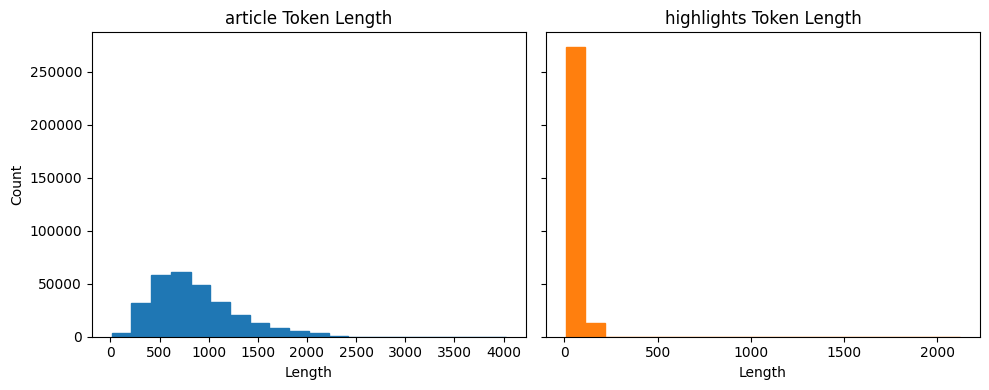

In [ ]:
import matplotlib.pyplot as plt

article_token_len = [len(tokenizer.encode(s)) for s in dataset_cnn['train']['article']]

highlights_token_len = [len(tokenizer.encode(s)) for s in dataset_cnn['train']['highlights']]


fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True )
axes[0].hist(article_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[0].set_title("article Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(highlights_token_len, bins = 20, color = 'C1', edgecolor = 'C1' )
axes[1].set_title("highlights Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()


In [ ]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['article'] , max_length = 1024, truncation = True )
    
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['highlights'], max_length = 128, truncation = True )
        
    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }
    
dataset_cnn_pt = dataset_cnn.map(convert_examples_to_features, remove_columns = ['id','article','highlights'],batched = True)

Map:   0%|          | 0/287113 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3606: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/13368 [00:00<?, ? examples/s]

Map:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [ ]:
from datasets import DatasetDict

# Assuming you have a DatasetDict object called dataset_dict
dataset_dict = DatasetDict({
    'train': dataset_cnn_pt['train'],  # Your train dataset
    'validation': dataset_cnn_pt['validation'],  # Your validation dataset
    'test': dataset_cnn_pt['test']  # Your test dataset
})

# Print 5 rows of a specific dataset within the DatasetDict
dataset_name = 'train'  # Specify the name of the dataset you want to print
dataset = dataset_dict[dataset_name]

print(dataset.head(5))


In [ ]:
dataset_cnn_pt

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 11490
    })
})

In [ ]:
#Print the first 5 rows of each dataset
for dataset_name, dataset in dataset_cnn_pt.items():
    print(f'{dataset_name}:')
    for i in range(5):
      print(dataset[i])
      print()

train:
{'input_ids': [45933, 108, 2159, 143, 25445, 158, 1315, 5849, 10173, 2187, 4767, 59988, 6602, 489, 112, 114, 1668, 25946, 604, 38589, 17593, 604, 158, 9490, 130, 178, 3043, 1204, 124, 1491, 108, 155, 178, 21031, 109, 408, 576, 131, 144, 2682, 114, 7779, 124, 342, 107, 4767, 59988, 130, 5849, 10173, 115, 198, 30827, 10173, 111, 109, 4257, 113, 109, 7045, 194, 413, 109, 11313, 113, 20581, 22803, 116, 279, 109, 278, 108, 109, 758, 5102, 649, 178, 148, 220, 1017, 112, 94670, 169, 1325, 429, 124, 991, 1732, 108, 2256, 111, 8913, 1829, 107, 198, 187, 272, 131, 144, 511, 112, 129, 156, 113, 274, 200, 170, 108, 130, 783, 130, 157, 795, 7739, 5008, 631, 1118, 114, 2926, 1537, 439, 949, 132, 364, 984, 745, 178, 898, 142, 2676, 27348, 1678, 136, 625, 107, 198, 187, 272, 131, 144, 311, 125, 131, 267, 129, 1533, 22948, 107, 198, 159, 341, 125, 172, 1783, 127, 341, 120, 519, 160, 377, 4118, 1315, 1031, 111, 15610, 111, 17371, 496, 654, 7739, 59988, 138, 129, 350, 112, 22299, 115, 114, 3080, 1

In [ ]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_pegasus)

In [ ]:
filtered_dataset = dataset_cnn_pt["train"].select(range(10000))
print(filtered_dataset)
print("Number of rows:", len(filtered_dataset))

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 10000
})
Number of rows: 10000


In [ ]:
!pip install --upgrade accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 6.2 MB/s eta 0:00:00


In [ ]:
!pip uninstall -y transformers accelerate
!pip install transformers accelerate

Found existing installation: transformers 4.29.0
Uninstalling transformers-4.29.0:
  Successfully uninstalled transformers-4.29.0
Found existing installation: accelerate 0.19.0
Uninstalling accelerate-0.19.0:
  Successfully uninstalled accelerate-0.19.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 43.6 MB/s eta 0:00:00
  Using cached accelerate-0.19.0-py3-none-any.whl (219 kB)


In [ ]:
from transformers import TrainingArguments, Trainer

trainer_args = TrainingArguments(
    output_dir='pegasus-cnn', num_train_epochs=2, warmup_steps=500,
    per_device_train_batch_size=3, per_device_eval_batch_size=2,
    weight_decay=0.01, logging_steps=10,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16)

In [ ]:
trainer = Trainer(model=model_pegasus, args=trainer_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_cnn_pt["train"].select(range(10000)), 
                  eval_dataset=dataset_cnn_pt["validation"].select(range(1000)))

In [ ]:
trainer.train()



Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


In [ ]:
#trial for smaller dataset by taking only 2000 from training and 200 from validation

In [ ]:
small_dataset = dataset_cnn.copy()

In [ ]:
#--------------------------

In [ ]:
from transformers import PegasusForConditionalGeneration, PegasusTokenizer, Trainer, TrainingArguments
import torch

In [ ]:
torch.__version__

'2.0.0+cu118'

In [ ]:
class PegasusDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels['input_ids'][idx])  # torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

In [ ]:
def prepare_data(model_name, 
                 train_texts, train_labels, 
                 val_texts, val_labels, 
                 test_texts=None, test_labels=None):
  """
  Prepare input data for model fine-tuning
  """
  tokenizer = PegasusTokenizer.from_pretrained(model_name)

  prepare_val = False if val_texts is None or val_labels is None else True
  prepare_test = False if test_texts is None or test_labels is None else True

  def tokenize_data(texts, labels):
    encodings = tokenizer(texts, truncation=True, padding=True)
    decodings = tokenizer(labels, truncation=True, padding=True)
    dataset_tokenized = PegasusDataset(encodings, decodings)
    return dataset_tokenized

  train_dataset = tokenize_data(train_texts, train_labels)
  val_dataset = tokenize_data(val_texts, val_labels) if prepare_val else None
  test_dataset = tokenize_data(test_texts, test_labels) if prepare_test else None

  return train_dataset, val_dataset, test_dataset

In [ ]:
def prepare_fine_tuning(model_name, train_dataset, val_dataset, freeze_encoder=False, output_dir='./results'):
  """
  Prepare configurations and base model for fine-tuning
  """
  torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'
  model = PegasusForConditionalGeneration.from_pretrained(model_name).to(torch_device)

  if freeze_encoder:
    for param in model.model.encoder.parameters():
      param.requires_grad = False

  if val_dataset is not None:
    training_args = TrainingArguments(
      output_dir=output_dir,           # output directory
      adafactor=True,                   # use adafactor instead of AdamW
      num_train_epochs=500,           # total number of training epochs
      per_device_train_batch_size=2,   # batch size per device during training, can increase if memory allows
      per_device_eval_batch_size=2,    # batch size for evaluation, can increase if memory allows
      save_steps=100,                  # number of updates steps before checkpoint saves
      save_total_limit=5,              # limit the total amount of checkpoints and deletes the older checkpoints
      evaluation_strategy='steps',     # evaluation strategy to adopt during training
      eval_steps=100,                  # number of update steps before evaluation
      warmup_steps=500,                # number of warmup steps for learning rate scheduler
      weight_decay=0.01,               # strength of weight decay
      logging_dir='./logs',            # directory for storing logs
      logging_steps=10,
    )

    trainer = Trainer(
      model=model,                         # the instantiated 🤗 Transformers model to be trained
      args=training_args,                  # training arguments, defined above
      train_dataset=train_dataset,         # training dataset
      eval_dataset=val_dataset             # evaluation dataset
    )

  else:
    training_args = TrainingArguments(
      output_dir=output_dir,           # output directory
      adafactor=True,                  # use adafactor instead of AdamW
      num_train_epochs=500,           # total number of training epochs
      per_device_train_batch_size=2,   # batch size per device during training, can increase if memory allows
      save_steps=100,                  # number of updates steps before checkpoint saves
      save_total_limit=5,              # limit the total amount of checkpoints and deletes the older checkpoints
      warmup_steps=500,                # number of warmup steps for learning rate scheduler
      weight_decay=0.01,               # strength of weight decay
      logging_dir='./logs',            # directory for storing logs
      logging_steps=10,
    )

    trainer = Trainer(
      model=model,                         # the instantiated 🤗 Transformers model to be trained
      args=training_args,                  # training arguments, defined above
      train_dataset=train_dataset,         # training dataset
    )

  return trainer

In [ ]:
# use cnn dataset as example, with first 2000 docs as training data

train_texts, train_labels = dataset_cnn['train']['article'][:10000], dataset_cnn['train']['highlights'][:10000]
#train_texts, train_labels = dataset['train']['document'], dataset['train']['summary']
val_texts, val_labels = dataset_cnn['validation']['article'][:500], dataset_cnn['validation']['highlights'][:500]

In [ ]:
len(train_texts)

2000

In [ ]:
len(val_texts)

200

In [ ]:
model_checkpoint = 'google/pegasus-large'
# about 8 mins to finish for the whole dataset
train_dataset, val_dataset, _ = prepare_data(model_checkpoint, train_texts, train_labels, val_texts, val_labels)


In [ ]:
%%time
# only about 1 minute
trainer = prepare_fine_tuning(model_checkpoint, train_dataset, val_dataset)

CPU times: user 16.6 s, sys: 4.09 s, total: 20.7 s
Wall time: 15 s


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1243: FutureWarning: `--adafactor` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--optim adafactor` instead
  warnings.warn(


In [ ]:
trainer.train()

Step,Training Loss,Validation Loss
100,5.566100,7.887821
200,3.953600,7.174061
300,3.135000,6.866641
400,1.440700,5.740567
500,0.072900,3.039482


TrainOutput(global_step=500, training_loss=3.389253124833107, metrics={'train_runtime': 4574.0307, 'train_samples_per_second': 0.219, 'train_steps_per_second': 0.109, 'total_flos': 2889464414208000.0, 'train_loss': 3.389253124833107, 'epoch': 500.0})

In [ ]:
!ls results/

checkpoint-100	checkpoint-200	checkpoint-300	checkpoint-400	checkpoint-500


In [ ]:
pegtokenizer  = PegasusTokenizer.from_pretrained(model_checkpoint)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

rouge_metric = load_metric('rouge')

In [ ]:
score = calculate_metric_on_test_ds(
    dataset_cnn['test'][:200], rouge_metric, trainer.model, pegtokenizer, batch_size = 2, column_text = 'article', column_summary= 'highlights'
)

rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = [f'pegasus'] )

  0%|          | 0/100 [00:00<?, ?it/s]

input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(94439)
vocabulary size: 96103


  1%|          | 1/100 [00:19<31:44, 19.24s/it]

torch.Size([2, 103])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95399)
vocabulary size: 96103


  2%|▏         | 2/100 [00:35<28:54, 17.69s/it]

torch.Size([2, 74])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(88480)
vocabulary size: 96103


  3%|▎         | 3/100 [00:53<28:46, 17.79s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95967)
vocabulary size: 96103


  4%|▍         | 4/100 [01:11<28:33, 17.85s/it]

torch.Size([2, 104])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(87575)
vocabulary size: 96103


  5%|▌         | 5/100 [01:29<28:05, 17.74s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(83660)
vocabulary size: 96103


  6%|▌         | 6/100 [01:43<25:45, 16.44s/it]

torch.Size([2, 53])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(88699)
vocabulary size: 96103


  7%|▋         | 7/100 [02:00<26:07, 16.85s/it]

torch.Size([2, 112])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(86888)
vocabulary size: 96103


  8%|▊         | 8/100 [02:16<25:22, 16.55s/it]

torch.Size([2, 86])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(92531)
vocabulary size: 96103


  9%|▉         | 9/100 [02:34<25:45, 16.98s/it]

torch.Size([2, 92])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(93359)
vocabulary size: 96103


 10%|█         | 10/100 [02:53<26:06, 17.40s/it]

torch.Size([2, 81])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(94811)
vocabulary size: 96103


 11%|█         | 11/100 [03:10<26:02, 17.56s/it]

torch.Size([2, 102])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(90790)
vocabulary size: 96103


 12%|█▏        | 12/100 [03:28<25:50, 17.62s/it]

torch.Size([2, 121])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95607)
vocabulary size: 96103


 13%|█▎        | 13/100 [03:46<25:35, 17.66s/it]

torch.Size([2, 126])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(94494)
vocabulary size: 96103


 14%|█▍        | 14/100 [04:04<25:24, 17.73s/it]

torch.Size([2, 103])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(93172)
vocabulary size: 96103


 15%|█▌        | 15/100 [04:22<25:24, 17.94s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95534)
vocabulary size: 96103


 16%|█▌        | 16/100 [04:40<25:02, 17.89s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95013)
vocabulary size: 96103


 17%|█▋        | 17/100 [04:58<24:47, 17.93s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(91755)
vocabulary size: 96103


 18%|█▊        | 18/100 [05:16<24:36, 18.01s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(93454)
vocabulary size: 96103


 19%|█▉        | 19/100 [05:36<25:00, 18.53s/it]

torch.Size([2, 99])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(92144)
vocabulary size: 96103


 20%|██        | 20/100 [05:54<24:30, 18.38s/it]

torch.Size([2, 74])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95460)
vocabulary size: 96103


 21%|██        | 21/100 [06:13<24:14, 18.41s/it]

torch.Size([2, 89])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(91955)
vocabulary size: 96103


 22%|██▏       | 22/100 [06:31<24:04, 18.52s/it]

torch.Size([2, 105])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(92172)
vocabulary size: 96103


 23%|██▎       | 23/100 [06:50<23:48, 18.55s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(88550)
vocabulary size: 96103


 24%|██▍       | 24/100 [07:08<23:22, 18.45s/it]

torch.Size([2, 85])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(91274)
vocabulary size: 96103


 25%|██▌       | 25/100 [07:27<23:09, 18.53s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(93338)
vocabulary size: 96103


 26%|██▌       | 26/100 [07:42<21:34, 17.49s/it]

torch.Size([2, 96])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(87608)
vocabulary size: 96103


 27%|██▋       | 27/100 [08:00<21:20, 17.54s/it]

torch.Size([2, 52])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(87023)
vocabulary size: 96103


 28%|██▊       | 28/100 [08:18<21:21, 17.80s/it]

torch.Size([2, 100])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(82016)
vocabulary size: 96103


 29%|██▉       | 29/100 [08:36<21:05, 17.83s/it]

torch.Size([2, 75])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(91223)
vocabulary size: 96103


 30%|███       | 30/100 [08:54<20:49, 17.85s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95379)
vocabulary size: 96103


 31%|███       | 31/100 [09:08<19:19, 16.80s/it]

torch.Size([2, 63])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(94207)
vocabulary size: 96103


 32%|███▏      | 32/100 [09:26<19:22, 17.10s/it]

torch.Size([2, 68])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95722)
vocabulary size: 96103


 33%|███▎      | 33/100 [09:44<19:34, 17.52s/it]

torch.Size([2, 70])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95775)
vocabulary size: 96103


 34%|███▍      | 34/100 [10:04<19:54, 18.11s/it]

torch.Size([2, 90])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(92627)
vocabulary size: 96103


 35%|███▌      | 35/100 [10:23<19:58, 18.44s/it]

torch.Size([2, 39])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(90892)
vocabulary size: 96103


 36%|███▌      | 36/100 [10:41<19:31, 18.30s/it]

torch.Size([2, 70])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(94709)
vocabulary size: 96103


 37%|███▋      | 37/100 [10:56<18:14, 17.38s/it]

torch.Size([2, 83])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(87002)
vocabulary size: 96103


 38%|███▊      | 38/100 [11:20<20:00, 19.37s/it]

torch.Size([2, 120])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(92818)
vocabulary size: 96103


 39%|███▉      | 39/100 [11:41<20:11, 19.86s/it]

torch.Size([2, 104])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(94872)
vocabulary size: 96103


 40%|████      | 40/100 [12:02<20:02, 20.04s/it]

torch.Size([2, 109])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(92539)
vocabulary size: 96103


 41%|████      | 41/100 [12:23<20:09, 20.50s/it]

torch.Size([2, 78])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95616)
vocabulary size: 96103


 42%|████▏     | 42/100 [12:45<20:11, 20.89s/it]

torch.Size([2, 91])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(90423)
vocabulary size: 96103


 43%|████▎     | 43/100 [13:04<19:08, 20.15s/it]

torch.Size([2, 46])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(89061)
vocabulary size: 96103


 44%|████▍     | 44/100 [13:27<19:50, 21.25s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(89875)
vocabulary size: 96103


 45%|████▌     | 45/100 [13:50<19:45, 21.56s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(82547)
vocabulary size: 96103


 46%|████▌     | 46/100 [14:11<19:16, 21.41s/it]

torch.Size([2, 94])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(89146)
vocabulary size: 96103


 47%|████▋     | 47/100 [14:35<19:39, 22.25s/it]

torch.Size([2, 85])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95659)
vocabulary size: 96103


 48%|████▊     | 48/100 [15:00<19:58, 23.05s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(90444)
vocabulary size: 96103


 49%|████▉     | 49/100 [15:25<20:01, 23.56s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(94712)
vocabulary size: 96103


 50%|█████     | 50/100 [15:47<19:27, 23.35s/it]

torch.Size([2, 67])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(83695)
vocabulary size: 96103


 51%|█████     | 51/100 [16:09<18:44, 22.95s/it]

torch.Size([2, 97])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(87185)
vocabulary size: 96103


 52%|█████▏    | 52/100 [16:32<18:13, 22.78s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95642)
vocabulary size: 96103


 53%|█████▎    | 53/100 [16:55<17:53, 22.84s/it]

torch.Size([2, 109])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(94229)
vocabulary size: 96103


 54%|█████▍    | 54/100 [17:17<17:25, 22.73s/it]

torch.Size([2, 56])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(92614)
vocabulary size: 96103


 55%|█████▌    | 55/100 [17:40<17:05, 22.80s/it]

torch.Size([2, 47])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95341)
vocabulary size: 96103


 56%|█████▌    | 56/100 [18:06<17:17, 23.57s/it]

torch.Size([2, 94])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(92719)
vocabulary size: 96103


 57%|█████▋    | 57/100 [18:28<16:31, 23.06s/it]

torch.Size([2, 71])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(89703)
vocabulary size: 96103


 58%|█████▊    | 58/100 [18:48<15:30, 22.15s/it]

torch.Size([2, 93])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(89786)
vocabulary size: 96103


 59%|█████▉    | 59/100 [19:09<15:05, 22.08s/it]

torch.Size([2, 105])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(81991)
vocabulary size: 96103


 60%|██████    | 60/100 [19:32<14:44, 22.12s/it]

torch.Size([2, 89])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(82274)
vocabulary size: 96103


 61%|██████    | 61/100 [19:54<14:26, 22.22s/it]

torch.Size([2, 71])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(92025)
vocabulary size: 96103


 62%|██████▏   | 62/100 [20:16<13:56, 22.02s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(94429)
vocabulary size: 96103


 63%|██████▎   | 63/100 [20:36<13:15, 21.50s/it]

torch.Size([2, 101])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(92771)
vocabulary size: 96103


 64%|██████▍   | 64/100 [20:57<12:50, 21.40s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(77960)
vocabulary size: 96103


 65%|██████▌   | 65/100 [21:18<12:22, 21.22s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95386)
vocabulary size: 96103


 66%|██████▌   | 66/100 [21:43<12:38, 22.32s/it]

torch.Size([2, 85])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(90981)
vocabulary size: 96103


 67%|██████▋   | 67/100 [22:07<12:33, 22.83s/it]

torch.Size([2, 82])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(86695)
vocabulary size: 96103


 68%|██████▊   | 68/100 [22:28<11:52, 22.25s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(93338)
vocabulary size: 96103


 69%|██████▉   | 69/100 [22:49<11:17, 21.86s/it]

torch.Size([2, 53])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(87158)
vocabulary size: 96103


 70%|███████   | 70/100 [23:04<09:59, 19.98s/it]

torch.Size([2, 60])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(92106)
vocabulary size: 96103


 71%|███████   | 71/100 [23:24<09:40, 20.02s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(92325)
vocabulary size: 96103


 72%|███████▏  | 72/100 [23:40<08:42, 18.67s/it]

torch.Size([2, 56])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(94815)
vocabulary size: 96103


 73%|███████▎  | 73/100 [23:58<08:17, 18.42s/it]

torch.Size([2, 81])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(93673)
vocabulary size: 96103


 74%|███████▍  | 74/100 [24:23<08:48, 20.34s/it]

torch.Size([2, 101])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(90091)
vocabulary size: 96103


 75%|███████▌  | 75/100 [24:45<08:41, 20.86s/it]

torch.Size([2, 122])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(92726)
vocabulary size: 96103


 76%|███████▌  | 76/100 [25:04<08:13, 20.56s/it]

torch.Size([2, 113])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(89723)
vocabulary size: 96103


 77%|███████▋  | 77/100 [25:24<07:48, 20.39s/it]

torch.Size([2, 71])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(93262)
vocabulary size: 96103


 78%|███████▊  | 78/100 [25:43<07:18, 19.91s/it]

torch.Size([2, 116])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(85528)
vocabulary size: 96103


 79%|███████▉  | 79/100 [26:04<07:00, 20.03s/it]

torch.Size([2, 70])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95775)
vocabulary size: 96103


 80%|████████  | 80/100 [26:24<06:42, 20.12s/it]

torch.Size([2, 82])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(94136)
vocabulary size: 96103


 81%|████████  | 81/100 [26:44<06:22, 20.13s/it]

torch.Size([2, 116])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95134)
vocabulary size: 96103


 82%|████████▏ | 82/100 [26:59<05:34, 18.56s/it]

torch.Size([2, 69])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95103)
vocabulary size: 96103


 83%|████████▎ | 83/100 [27:21<05:31, 19.50s/it]

torch.Size([2, 72])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(91999)
vocabulary size: 96103


 84%|████████▍ | 84/100 [27:35<04:49, 18.09s/it]

torch.Size([2, 87])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(93872)
vocabulary size: 96103


 85%|████████▌ | 85/100 [27:55<04:35, 18.38s/it]

torch.Size([2, 99])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(90919)
vocabulary size: 96103


 86%|████████▌ | 86/100 [28:14<04:22, 18.72s/it]

torch.Size([2, 114])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(88366)
vocabulary size: 96103


 87%|████████▋ | 87/100 [28:37<04:20, 20.01s/it]

torch.Size([2, 105])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(90955)
vocabulary size: 96103


 88%|████████▊ | 88/100 [29:01<04:15, 21.32s/it]

torch.Size([2, 110])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(88057)
vocabulary size: 96103


 89%|████████▉ | 89/100 [29:30<04:18, 23.54s/it]

torch.Size([2, 112])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(94393)
vocabulary size: 96103


 90%|█████████ | 90/100 [29:41<03:18, 19.86s/it]

torch.Size([2, 70])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(91133)
vocabulary size: 96103


 91%|█████████ | 91/100 [29:59<02:53, 19.26s/it]

torch.Size([2, 96])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95134)
vocabulary size: 96103


 92%|█████████▏| 92/100 [30:17<02:30, 18.85s/it]

torch.Size([2, 86])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(78243)
vocabulary size: 96103


 93%|█████████▎| 93/100 [30:35<02:10, 18.58s/it]

torch.Size([2, 86])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(88125)
vocabulary size: 96103


 94%|█████████▍| 94/100 [30:45<01:36, 16.05s/it]

torch.Size([2, 48])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(90254)
vocabulary size: 96103


 95%|█████████▌| 95/100 [30:59<01:17, 15.40s/it]

torch.Size([2, 78])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(89872)
vocabulary size: 96103


 96%|█████████▌| 96/100 [31:17<01:05, 16.27s/it]

torch.Size([2, 93])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(93615)
vocabulary size: 96103


 97%|█████████▋| 97/100 [31:36<00:50, 16.90s/it]

torch.Size([2, 50])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(85793)
vocabulary size: 96103


 98%|█████████▊| 98/100 [31:54<00:34, 17.32s/it]

torch.Size([2, 40])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(92542)
vocabulary size: 96103


 99%|█████████▉| 99/100 [32:07<00:15, 15.86s/it]

torch.Size([2, 55])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(91219)
vocabulary size: 96103


100%|██████████| 100/100 [32:24<00:00, 19.45s/it]

torch.Size([2, 100])
torch.Size([2, 1024])


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.257284,0.086007,0.176206,0.21146


In [ ]:
!ls results/checkpoint-500/

config.json		optimizer.pt	   rng_state.pth  trainer_state.json
generation_config.json	pytorch_model.bin  scheduler.pt   training_args.bin


In [ ]:
torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'
tokenizer = PegasusTokenizer.from_pretrained('google/pegasus-large')

In [ ]:
# load the finetuned model
model_path = "./results/checkpoint-500/"
model_finetune = PegasusForConditionalGeneration.from_pretrained(model_path, local_files_only=True).to(torch_device)

In [ ]:
model_large = PegasusForConditionalGeneration.from_pretrained('google/pegasus-large').to(torch_device)

In [ ]:
# load the pegasus multinews model
model_cnn = PegasusForConditionalGeneration.from_pretrained('google/pegasus-cnn_dailymail').to(torch_device)

In [ ]:
def show_result(src_text, model):
  batch = tokenizer.prepare_seq2seq_batch(src_text, truncation=True, padding='longest', return_tensors="pt").to(torch_device)
  translated = model.generate(**batch)
  gen_text = tokenizer.batch_decode(translated, skip_special_tokens=True)
  return gen_text

In [ ]:
# after fine tune xsum dataset the result is same as large 
# but the result from official xsum fine tuned model is different
text_1 = [
    """ 
    The Tesla CEO, Elon Musk has fallen to the third spot in the list of 
    the Forbes billionaire rankings after a significant fall in 
    Tesla shares recently. The billionaire lost close to $6.2 billion 
    by the end of the day on Wednesday. 
    Musk's overall wealth has fallen down dramatic since January when 
    the Tesla CEO was valued at around $197 billion and after the 
    consecutive fall within the last few weeks, Musk is now valued at 
    $150.900 billion, as per Forbes's real-time billionaire's list.
    While Amazon's CEO Jeff Bezos appears to be unshakable at the number 
    one position at $175.4 billion, the second spot has now been claimed 
    by the French billionaire Bernard Arnault who is the owner conglomerate 
    LVMH , with a fortune of $ 155.600 billion. For the record, the LVMH group 
    encompasses over 70 luxury brands including Fendi, Givenchy, Louis Vuitton, 
    Christian Dior, Marc Jacobs, Fenty Beauty, 
    Bvlgari, Tiffany & Co. and Sephora.
    """
]

text_2 = [
    """ 
    China's national soccer team could call back four players from overseas 
to boost its chances at the Asian Games in Thailand in December, an 
official newspaper reported Monday. Two of the players, Fan Zhiyi 
and Sun Jihai, play for Crystal Palace in the English First Division. 
Another, Yang Chen, plays in Germany, while Li Jinyu is with Nantes 
in France. Englishman Bob Houghton, who coaches the national team, 
said recalling Fan and Sun for the Asian Games would allow him to 
``see if they can bring the things they have learned recently in England 
to the national team,'' the China Sports Daily said. Houghton also 
said that Yang, who plays in Frankfurt, ``very possibly could become 
an extremely important player in the national team,'' the newspaper 
reported. Li, who has not had many chances to play since his move 
to France, also ``is very willing to come back,'' the newspaper said. 
China and South Korea will both field their Asian Games teams at a 
friendly warm-up match Nov. 22, the newspaper said. The Asian Games 
are held every four years. 
    """
]


print('my fine-tuned model result 1:', show_result(text_1, model_finetune))
print('--------------------')
print('\n')
print('\n')
print('official large model result 1:', show_result(text_1, model_cnn))
print('**************************************************')
print('my fine-tuned model result 2:', show_result(text_2, model_finetune))
print('--------------------')
print('\n')
print('\n')
print('official multinews model result 2:', show_result(text_2, model_cnn))
print('official pegasus large model result 2:', show_result(text_2, model_large))

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3722: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and targets.

Here is a short example:

model_inputs = tokenizer(src_texts, text_target=tgt_texts, ...)

If you either need to use different keyword arguments for the source and target texts, you should do two calls like
this:

model_inputs = tokenizer(src_texts, ...)
labels = tokenizer(text_target=tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (256) t

my fine-tuned model result 1: ["Musk's overall wealth has fallen down dramatic since January when the Tesla CEO was valued at around $197 billion and after the consecutive fall within the last few weeks, Musk is now valued at $150.900 billion, as per Forbes's real-time billionaire's list."]
--------------------






/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (128) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


official large model result 1: ["The Tesla CEO, Elon Musk has fallen to the third spot in the list of the Forbes billionaire rankings after a significant fall in Tesla shares recently.<n>The billionaire lost close to $6.2 billion by the end of the day on Wednesday.<n>While Amazon's CEO Jeff Bezos appears to be unshakable at the number one position at $175.4 billion, the second spot has now been claimed by the French billionaire Bernard Arnault."]
**************************************************
my fine-tuned model result 2: ["Englishman Bob Houghton, who coaches the national team, said recalling Fan and Sun for the Asian Games would allow him to see if they can bring the things they have learned recently in England to the national team,'' the China Sports Daily said."]
--------------------




official multinews model result 2: ['China could call back four players from overseas to boost its chances at the Asian Games in Thailand in December.<n>Two of the players, Fan Zhiyi and Sun Ji

**Using transformed (augmented) data**

In [ ]:
#####trying to use augmented dataset. convert pandas dataframe to dataset dictionary

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/final/augmented_train3.csv')

In [ ]:
df.shape

(480289, 2)

In [ ]:
#importing the cleaned and preprocessed test csv file exported from jupyter notebook
test_df = pd.read_csv('/content/drive/MyDrive/final/cleaned_test.csv')

In [ ]:
test_df.shape

(15441, 2)

In [ ]:
#importing the cleaned and preprocessed test csv file exported from jupyter notebook
val_df = pd.read_csv('/content/drive/MyDrive/final/cleaned_val.csv')

In [ ]:
val_df.shape

(15442, 2)

In [ ]:
#shuffling all the rows so that original and augmented data rows gets mixed
train_df = df.sample(frac=1, random_state=42)


In [ ]:
# reset index
train_df.reset_index(drop=True, inplace=True)

In [ ]:
from datasets import Dataset, DatasetDict

# convert DataFrame to DatasetDict
dataset_dict = DatasetDict({
    "train": Dataset.from_pandas(train_df[["article", "highlights"]]),
    "validation": Dataset.from_pandas(val_df[["article", "highlights"]]),
    "test": Dataset.from_pandas(test_df[["article", "highlights"]]),
})

In [ ]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights'],
        num_rows: 480289
    })
    validation: Dataset({
        features: ['article', 'highlights'],
        num_rows: 15442
    })
    test: Dataset({
        features: ['article', 'highlights'],
        num_rows: 15441
    })
})

In [ ]:
from transformers import PegasusForConditionalGeneration, PegasusTokenizer, Trainer, TrainingArguments
import torch

In [ ]:
class PegasusDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels['input_ids'][idx])  # torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

In [ ]:
def prepare_data(model_name, 
                 train_texts, train_labels, 
                 val_texts, val_labels, 
                 test_texts=None, test_labels=None):
  """
  Prepare input data for model fine-tuning
  """
  tokenizer = PegasusTokenizer.from_pretrained(model_name)

  prepare_val = False if val_texts is None or val_labels is None else True
  prepare_test = False if test_texts is None or test_labels is None else True

  def tokenize_data(texts, labels):
    encodings = tokenizer(texts, truncation=True, padding=True)
    decodings = tokenizer(labels, truncation=True, padding=True)
    dataset_tokenized = PegasusDataset(encodings, decodings)
    return dataset_tokenized

  train_dataset = tokenize_data(train_texts, train_labels)
  val_dataset = tokenize_data(val_texts, val_labels) if prepare_val else None
  test_dataset = tokenize_data(test_texts, test_labels) if prepare_test else None

  return train_dataset, val_dataset, test_dataset

In [ ]:
def prepare_fine_tuning(model_name, train_dataset, val_dataset, freeze_encoder=False, output_dir='./results'):
  """
  Prepare configurations and base model for fine-tuning
  """
  torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'
  model = PegasusForConditionalGeneration.from_pretrained(model_name).to(torch_device)

  if freeze_encoder:
    for param in model.model.encoder.parameters():
      param.requires_grad = False

  if val_dataset is not None:
    training_args = TrainingArguments(
      output_dir=output_dir,           # output directory
      #adafactor=True, 
      AdamW=True,                 # use adafactor instead of AdamW
      num_train_epochs=200,           # total number of training epochs
      per_device_train_batch_size=2,   # batch size per device during training, can increase if memory allows
      per_device_eval_batch_size=2,    # batch size for evaluation, can increase if memory allows
      save_steps=100,                  # number of updates steps before checkpoint saves
      save_total_limit=5,              # limit the total amount of checkpoints and deletes the older checkpoints
      evaluation_strategy='steps',     # evaluation strategy to adopt during training
      eval_steps=100,                  # number of update steps before evaluation
      warmup_steps=500,                # number of warmup steps for learning rate scheduler
      weight_decay=0.01,               # strength of weight decay
      logging_dir='./logs',            # directory for storing logs
      logging_steps=10,
    )

    trainer = Trainer(
      model=model,                         # the instantiated 🤗 Transformers model to be trained
      args=training_args,                  # training arguments, defined above
      train_dataset=train_dataset,         # training dataset
      eval_dataset=val_dataset             # evaluation dataset
    )

  else:
    training_args = TrainingArguments(
      output_dir=output_dir,           # output directory
      adafactor=True,                  # use adafactor instead of AdamW
      num_train_epochs=1000,           # total number of training epochs
      per_device_train_batch_size=2,   # batch size per device during training, can increase if memory allows
      save_steps=100,                  # number of updates steps before checkpoint saves
      save_total_limit=5,              # limit the total amount of checkpoints and deletes the older checkpoints
      warmup_steps=500,                # number of warmup steps for learning rate scheduler
      weight_decay=0.01,               # strength of weight decay
      logging_dir='./logs',            # directory for storing logs
      logging_steps=10,
    )

    trainer = Trainer(
      model=model,                         # the instantiated 🤗 Transformers model to be trained
      args=training_args,                  # training arguments, defined above
      train_dataset=train_dataset,         # training dataset
    )

  return trainer

In [ ]:
# use cnn dataset, with first 100, 1000, 2000, 5000, 10000 docs as training data

train_texts, train_labels = dataset_dict['train']['article'][:10000], dataset_dict['train']['highlights'][:10000]
#train_texts, train_labels = dataset['train']['document'], dataset['train']['summary']
val_texts, val_labels = dataset_dict['validation']['article'][:1000], dataset_dict['validation']['highlights'][:1000]

In [ ]:
model_checkpoint = 'google/pegasus-large'
# about 8 mins to finish for the whole dataset
train_dataset, val_dataset, _ = prepare_data(model_checkpoint, train_texts, train_labels, val_texts, val_labels)


In [ ]:
print(train_dataset)

In [ ]:
%%time
# only about 1 minute
trainer = prepare_fine_tuning(model_checkpoint, train_dataset, val_dataset)

CPU times: user 20.5 s, sys: 10.4 s, total: 31 s
Wall time: 28.9 s


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1243: FutureWarning: `--adafactor` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--optim adafactor` instead
  warnings.warn(


In [ ]:
trainer.train()

Step,Training Loss,Validation Loss
100,9.049100,9.799663
200,7.516100,9.609241
300,5.399300,8.949566
400,1.179500,5.969426
500,0.027800,2.549798
600,0.004800,4.226098
700,0.004300,3.185999
800,0.001900,2.760791
900,0.000600,2.571616
1000,0.003500,2.650543


TrainOutput(global_step=1000, training_loss=2.7978585387831556, metrics={'train_runtime': 11015.3286, 'train_samples_per_second': 0.182, 'train_steps_per_second': 0.091, 'total_flos': 5778928828416000.0, 'train_loss': 2.7978585387831556, 'epoch': 1000.0})

In [ ]:
!ls /content/drive/MyDrive/final/results/

checkpoint-1000  checkpoint-600  checkpoint-700  checkpoint-800  checkpoint-900


In [ ]:
model_checkpoint = 'google/pegasus-large'

In [ ]:
!pip install rouge_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pegtokenizer  = PegasusTokenizer.from_pretrained(model_checkpoint)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

rouge_metric = load_metric('rouge')

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:

score = calculate_metric_on_test_ds(
    dataset_dict['test'][:500], rouge_metric, trainer.model, pegtokenizer, batch_size = 2, column_text = 'article', column_summary= 'highlights'
)

rouge_dict = dict((rn, score[rn].high.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = [f'pegasus'] )

  0%|          | 0/250 [00:00<?, ?it/s]

input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95824)
vocabulary size: 96103


  0%|          | 1/250 [00:22<1:34:30, 22.77s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(92829)
vocabulary size: 96103


  1%|          | 2/250 [00:43<1:29:36, 21.68s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(93505)
vocabulary size: 96103


  1%|          | 3/250 [01:04<1:27:36, 21.28s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(92006)
vocabulary size: 96103


  2%|▏         | 4/250 [01:26<1:28:40, 21.63s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(93676)
vocabulary size: 96103


  2%|▏         | 5/250 [01:47<1:26:41, 21.23s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95559)
vocabulary size: 96103


  2%|▏         | 6/250 [02:07<1:25:10, 20.95s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(88903)
vocabulary size: 96103


  3%|▎         | 7/250 [02:28<1:24:41, 20.91s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(85666)
vocabulary size: 96103


  3%|▎         | 8/250 [02:50<1:25:48, 21.27s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(92539)
vocabulary size: 96103


  4%|▎         | 9/250 [03:10<1:24:23, 21.01s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(89038)
vocabulary size: 96103


  4%|▍         | 10/250 [03:31<1:23:40, 20.92s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95655)
vocabulary size: 96103


  4%|▍         | 11/250 [03:52<1:23:12, 20.89s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95655)
vocabulary size: 96103


  5%|▍         | 12/250 [04:13<1:23:07, 20.95s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(94875)
vocabulary size: 96103


  5%|▌         | 13/250 [04:34<1:22:23, 20.86s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(93307)
vocabulary size: 96103


  6%|▌         | 14/250 [04:54<1:21:20, 20.68s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(92339)
vocabulary size: 96103


  6%|▌         | 15/250 [05:15<1:21:09, 20.72s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(84512)
vocabulary size: 96103


  6%|▋         | 16/250 [05:39<1:24:47, 21.74s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(86233)
vocabulary size: 96103


  7%|▋         | 17/250 [06:00<1:23:46, 21.57s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(89736)
vocabulary size: 96103


  7%|▋         | 18/250 [06:21<1:22:17, 21.28s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(89322)
vocabulary size: 96103


  8%|▊         | 19/250 [06:41<1:21:06, 21.07s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95569)
vocabulary size: 96103


  8%|▊         | 20/250 [07:03<1:21:34, 21.28s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95814)
vocabulary size: 96103


  8%|▊         | 21/250 [07:24<1:20:51, 21.19s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95655)
vocabulary size: 96103


  9%|▉         | 22/250 [07:45<1:19:58, 21.04s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(93998)
vocabulary size: 96103


  9%|▉         | 23/250 [08:06<1:19:28, 21.01s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(91488)
vocabulary size: 96103


 10%|▉         | 24/250 [08:28<1:20:30, 21.37s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(94736)
vocabulary size: 96103


 10%|█         | 25/250 [08:49<1:19:57, 21.32s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(92943)
vocabulary size: 96103


 10%|█         | 26/250 [09:10<1:19:06, 21.19s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(94747)
vocabulary size: 96103


 11%|█         | 27/250 [09:31<1:18:26, 21.10s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(94082)
vocabulary size: 96103


 11%|█         | 28/250 [09:53<1:19:15, 21.42s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(92041)
vocabulary size: 96103


 12%|█▏        | 29/250 [10:14<1:18:11, 21.23s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(92296)
vocabulary size: 96103


 12%|█▏        | 30/250 [10:34<1:17:13, 21.06s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95655)
vocabulary size: 96103


 12%|█▏        | 31/250 [10:56<1:17:11, 21.15s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(92646)
vocabulary size: 96103


 13%|█▎        | 32/250 [11:17<1:16:47, 21.14s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(91434)
vocabulary size: 96103


 13%|█▎        | 33/250 [11:38<1:16:10, 21.06s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(93963)
vocabulary size: 96103


 14%|█▎        | 34/250 [11:58<1:15:24, 20.95s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95607)
vocabulary size: 96103


 14%|█▍        | 35/250 [12:19<1:14:33, 20.81s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(93818)
vocabulary size: 96103


 14%|█▍        | 36/250 [12:41<1:15:21, 21.13s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95655)
vocabulary size: 96103


 15%|█▍        | 37/250 [13:02<1:14:33, 21.00s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(80834)
vocabulary size: 96103


 15%|█▌        | 38/250 [13:22<1:13:52, 20.91s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(90913)
vocabulary size: 96103


 16%|█▌        | 39/250 [13:43<1:13:27, 20.89s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(93307)
vocabulary size: 96103


 16%|█▌        | 40/250 [14:04<1:13:31, 21.01s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(89479)
vocabulary size: 96103


 16%|█▋        | 41/250 [14:26<1:14:08, 21.29s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95020)
vocabulary size: 96103


 17%|█▋        | 42/250 [14:47<1:12:50, 21.01s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(93386)
vocabulary size: 96103


 17%|█▋        | 43/250 [15:07<1:12:07, 20.91s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95085)
vocabulary size: 96103


 18%|█▊        | 44/250 [15:28<1:11:47, 20.91s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(92953)
vocabulary size: 96103


 18%|█▊        | 45/250 [15:50<1:11:48, 21.02s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(89575)
vocabulary size: 96103


 18%|█▊        | 46/250 [16:10<1:10:58, 20.88s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(94208)
vocabulary size: 96103


 19%|█▉        | 47/250 [16:31<1:10:20, 20.79s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(94760)
vocabulary size: 96103


 19%|█▉        | 48/250 [16:51<1:09:48, 20.73s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(89770)
vocabulary size: 96103


 20%|█▉        | 49/250 [17:12<1:09:56, 20.88s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(87635)
vocabulary size: 96103


 20%|██        | 50/250 [17:34<1:10:36, 21.18s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(94144)
vocabulary size: 96103


 20%|██        | 51/250 [17:59<1:14:09, 22.36s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(88835)
vocabulary size: 96103


 21%|██        | 52/250 [18:20<1:12:24, 21.94s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95545)
vocabulary size: 96103


 21%|██        | 53/250 [18:42<1:11:22, 21.74s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(93346)
vocabulary size: 96103


 22%|██▏       | 54/250 [19:02<1:09:56, 21.41s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(89736)
vocabulary size: 96103


 22%|██▏       | 55/250 [19:23<1:08:37, 21.12s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(94208)
vocabulary size: 96103


 22%|██▏       | 56/250 [19:43<1:07:43, 20.95s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(92174)
vocabulary size: 96103


 23%|██▎       | 57/250 [20:05<1:08:11, 21.20s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95274)
vocabulary size: 96103


 23%|██▎       | 58/250 [20:25<1:06:56, 20.92s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(87789)
vocabulary size: 96103


 24%|██▎       | 59/250 [20:46<1:06:01, 20.74s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(93307)
vocabulary size: 96103


 24%|██▍       | 60/250 [21:06<1:05:14, 20.60s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(94736)
vocabulary size: 96103


 24%|██▍       | 61/250 [21:27<1:05:20, 20.74s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(92512)
vocabulary size: 96103


 25%|██▍       | 62/250 [21:49<1:06:05, 21.09s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(90677)
vocabulary size: 96103


 25%|██▌       | 63/250 [22:10<1:05:37, 21.05s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(88961)
vocabulary size: 96103


 26%|██▌       | 64/250 [22:31<1:05:28, 21.12s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(89694)
vocabulary size: 96103


 26%|██▌       | 65/250 [22:54<1:06:58, 21.72s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95370)
vocabulary size: 96103


 26%|██▋       | 66/250 [23:16<1:06:39, 21.74s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(92814)
vocabulary size: 96103


 27%|██▋       | 67/250 [23:38<1:06:00, 21.64s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(92339)
vocabulary size: 96103


 27%|██▋       | 68/250 [23:59<1:05:51, 21.71s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(88270)
vocabulary size: 96103


 28%|██▊       | 69/250 [24:23<1:06:52, 22.17s/it]

torch.Size([2, 87])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(92393)
vocabulary size: 96103


 28%|██▊       | 70/250 [24:44<1:06:10, 22.06s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(92814)
vocabulary size: 96103


 28%|██▊       | 71/250 [25:06<1:05:05, 21.82s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(81824)
vocabulary size: 96103


 29%|██▉       | 72/250 [25:28<1:05:22, 22.04s/it]

torch.Size([2, 84])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95655)
vocabulary size: 96103


 29%|██▉       | 73/250 [25:51<1:05:39, 22.25s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(92549)
vocabulary size: 96103


 30%|██▉       | 74/250 [26:12<1:04:37, 22.03s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(94439)
vocabulary size: 96103


 30%|███       | 75/250 [26:34<1:04:06, 21.98s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(86029)
vocabulary size: 96103


 30%|███       | 76/250 [26:56<1:03:40, 21.96s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(93307)
vocabulary size: 96103


 31%|███       | 77/250 [27:18<1:02:43, 21.75s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(91116)
vocabulary size: 96103


 31%|███       | 78/250 [27:39<1:02:04, 21.65s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(94875)
vocabulary size: 96103


 32%|███▏      | 79/250 [28:01<1:02:04, 21.78s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(93293)
vocabulary size: 96103


 32%|███▏      | 80/250 [28:23<1:01:45, 21.80s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(96081)
vocabulary size: 96103


 32%|███▏      | 81/250 [28:44<1:01:09, 21.71s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(94144)
vocabulary size: 96103


 33%|███▎      | 82/250 [29:07<1:01:36, 22.00s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(88279)
vocabulary size: 96103


 33%|███▎      | 83/250 [29:30<1:01:36, 22.14s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(93055)
vocabulary size: 96103


 34%|███▎      | 84/250 [29:52<1:01:09, 22.10s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(93307)
vocabulary size: 96103


 34%|███▍      | 85/250 [30:13<1:00:26, 21.98s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(83022)
vocabulary size: 96103


 34%|███▍      | 86/250 [30:34<59:15, 21.68s/it]  

torch.Size([2, 66])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(92437)
vocabulary size: 96103


 35%|███▍      | 87/250 [30:56<59:16, 21.82s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95554)
vocabulary size: 96103


 35%|███▌      | 88/250 [31:18<58:44, 21.76s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(83318)
vocabulary size: 96103


 36%|███▌      | 89/250 [31:40<58:22, 21.76s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(94823)
vocabulary size: 96103


 36%|███▌      | 90/250 [32:02<58:40, 22.01s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(93528)
vocabulary size: 96103


 36%|███▋      | 91/250 [32:25<58:42, 22.15s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(94875)
vocabulary size: 96103


 37%|███▋      | 92/250 [32:47<58:16, 22.13s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(94760)
vocabulary size: 96103


 37%|███▋      | 93/250 [33:09<58:09, 22.23s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(91185)
vocabulary size: 96103


 38%|███▊      | 94/250 [33:32<58:03, 22.33s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95199)
vocabulary size: 96103


 38%|███▊      | 95/250 [33:54<57:15, 22.16s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(88968)
vocabulary size: 96103


 38%|███▊      | 96/250 [34:15<56:30, 22.02s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95655)
vocabulary size: 96103


 39%|███▉      | 97/250 [34:38<56:24, 22.12s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95199)
vocabulary size: 96103


 39%|███▉      | 98/250 [35:00<55:55, 22.07s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(86891)
vocabulary size: 96103


 40%|███▉      | 99/250 [35:21<54:54, 21.82s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(94648)
vocabulary size: 96103


 40%|████      | 100/250 [35:43<54:23, 21.76s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95540)
vocabulary size: 96103


 40%|████      | 101/250 [36:05<54:21, 21.89s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(93634)
vocabulary size: 96103


 41%|████      | 102/250 [36:26<53:45, 21.80s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(90763)
vocabulary size: 96103


 41%|████      | 103/250 [36:47<52:55, 21.60s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(93818)
vocabulary size: 96103


 42%|████▏     | 104/250 [37:09<52:43, 21.67s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(92547)
vocabulary size: 96103


 42%|████▏     | 105/250 [37:32<52:51, 21.87s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(94530)
vocabulary size: 96103


 42%|████▏     | 106/250 [37:53<52:04, 21.70s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(72643)
vocabulary size: 96103


 43%|████▎     | 107/250 [38:14<51:26, 21.59s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(90098)
vocabulary size: 96103


 43%|████▎     | 108/250 [38:36<51:07, 21.60s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(94674)
vocabulary size: 96103


 44%|████▎     | 109/250 [38:57<50:42, 21.58s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(94864)
vocabulary size: 96103


 44%|████▍     | 110/250 [39:19<50:07, 21.48s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(89995)
vocabulary size: 96103


 44%|████▍     | 111/250 [39:40<49:46, 21.48s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(89114)
vocabulary size: 96103


 45%|████▍     | 112/250 [40:02<49:42, 21.61s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(83803)
vocabulary size: 96103


 45%|████▌     | 113/250 [40:24<49:34, 21.71s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95707)
vocabulary size: 96103


 46%|████▌     | 114/250 [40:45<48:44, 21.50s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95139)
vocabulary size: 96103


 46%|████▌     | 115/250 [41:06<48:09, 21.41s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(89038)
vocabulary size: 96103


 46%|████▋     | 116/250 [41:28<47:57, 21.47s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(85896)
vocabulary size: 96103


 47%|████▋     | 117/250 [41:50<47:46, 21.55s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(84421)
vocabulary size: 96103


 47%|████▋     | 118/250 [42:12<48:15, 21.94s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(94830)
vocabulary size: 96103


 48%|████▊     | 119/250 [42:33<47:16, 21.65s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(92676)
vocabulary size: 96103


 48%|████▊     | 120/250 [42:55<46:46, 21.59s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95783)
vocabulary size: 96103


 48%|████▊     | 121/250 [43:17<46:30, 21.63s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(94208)
vocabulary size: 96103


 49%|████▉     | 122/250 [43:38<45:48, 21.47s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95655)
vocabulary size: 96103


 49%|████▉     | 123/250 [43:59<45:07, 21.32s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(91497)
vocabulary size: 96103


 50%|████▉     | 124/250 [44:20<44:57, 21.41s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(91889)
vocabulary size: 96103


 50%|█████     | 125/250 [44:42<44:37, 21.42s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(92943)
vocabulary size: 96103


 50%|█████     | 126/250 [45:03<44:03, 21.32s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95655)
vocabulary size: 96103


 51%|█████     | 127/250 [45:23<43:18, 21.12s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(88983)
vocabulary size: 96103


 51%|█████     | 128/250 [45:44<42:45, 21.03s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95556)
vocabulary size: 96103


 52%|█████▏    | 129/250 [46:06<42:45, 21.20s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95832)
vocabulary size: 96103


 52%|█████▏    | 130/250 [46:27<42:11, 21.09s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(89672)
vocabulary size: 96103


 52%|█████▏    | 131/250 [46:41<38:03, 19.19s/it]

torch.Size([2, 87])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(94517)
vocabulary size: 96103


 53%|█████▎    | 132/250 [47:02<38:36, 19.63s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95778)
vocabulary size: 96103


 53%|█████▎    | 133/250 [47:23<38:55, 19.96s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95848)
vocabulary size: 96103


 54%|█████▎    | 134/250 [47:44<39:24, 20.39s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95978)
vocabulary size: 96103


 54%|█████▍    | 135/250 [48:05<39:35, 20.65s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(89770)
vocabulary size: 96103


 54%|█████▍    | 136/250 [48:26<39:23, 20.73s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(93645)
vocabulary size: 96103


 55%|█████▍    | 137/250 [48:47<39:03, 20.74s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95655)
vocabulary size: 96103


 55%|█████▌    | 138/250 [49:08<38:57, 20.87s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95559)
vocabulary size: 96103


 56%|█████▌    | 139/250 [49:30<38:56, 21.05s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(94467)
vocabulary size: 96103


 56%|█████▌    | 140/250 [49:51<38:31, 21.02s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(73492)
vocabulary size: 96103


 56%|█████▋    | 141/250 [50:12<38:13, 21.04s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(93399)
vocabulary size: 96103


 57%|█████▋    | 142/250 [50:34<38:17, 21.27s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(91599)
vocabulary size: 96103


 57%|█████▋    | 143/250 [50:55<37:52, 21.24s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95025)
vocabulary size: 96103


 58%|█████▊    | 144/250 [51:16<37:24, 21.17s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(80663)
vocabulary size: 96103


 58%|█████▊    | 145/250 [51:37<36:48, 21.03s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(88967)
vocabulary size: 96103


 58%|█████▊    | 146/250 [51:58<36:38, 21.14s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(91191)
vocabulary size: 96103


 59%|█████▉    | 147/250 [52:19<36:10, 21.07s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(89114)
vocabulary size: 96103


 59%|█████▉    | 148/250 [52:40<35:41, 20.99s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(91593)
vocabulary size: 96103


 60%|█████▉    | 149/250 [53:01<35:16, 20.96s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(91599)
vocabulary size: 96103


 60%|██████    | 150/250 [53:21<34:50, 20.90s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(91116)
vocabulary size: 96103


 60%|██████    | 151/250 [53:43<34:55, 21.16s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(93307)
vocabulary size: 96103


 61%|██████    | 152/250 [54:04<34:26, 21.09s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(88441)
vocabulary size: 96103


 61%|██████    | 153/250 [54:25<33:56, 21.00s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(82486)
vocabulary size: 96103


 62%|██████▏   | 154/250 [54:45<33:16, 20.80s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(92059)
vocabulary size: 96103


 62%|██████▏   | 155/250 [55:06<32:59, 20.84s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95543)
vocabulary size: 96103


 62%|██████▏   | 156/250 [55:27<32:53, 20.99s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(83699)
vocabulary size: 96103


 63%|██████▎   | 157/250 [55:48<32:28, 20.95s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(92601)
vocabulary size: 96103


 63%|██████▎   | 158/250 [56:09<32:01, 20.89s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(93012)
vocabulary size: 96103


 64%|██████▎   | 159/250 [56:29<31:29, 20.77s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(94517)
vocabulary size: 96103


 64%|██████▍   | 160/250 [56:51<31:33, 21.04s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(93513)
vocabulary size: 96103


 64%|██████▍   | 161/250 [57:13<31:25, 21.18s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(88180)
vocabulary size: 96103


 65%|██████▍   | 162/250 [57:33<30:47, 20.99s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95920)
vocabulary size: 96103


 65%|██████▌   | 163/250 [57:54<30:18, 20.90s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(93759)
vocabulary size: 96103


 66%|██████▌   | 164/250 [58:15<30:05, 21.00s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(92509)
vocabulary size: 96103


 66%|██████▌   | 165/250 [58:36<29:42, 20.96s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95567)
vocabulary size: 96103


 66%|██████▋   | 166/250 [58:57<29:19, 20.95s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(89770)
vocabulary size: 96103


 67%|██████▋   | 167/250 [59:18<28:51, 20.86s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(86350)
vocabulary size: 96103


 67%|██████▋   | 168/250 [59:38<28:24, 20.78s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(92549)
vocabulary size: 96103


 68%|██████▊   | 169/250 [1:00:00<28:35, 21.18s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(93670)
vocabulary size: 96103


 68%|██████▊   | 170/250 [1:00:21<27:59, 21.00s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(87312)
vocabulary size: 96103


 68%|██████▊   | 171/250 [1:00:42<27:33, 20.94s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(90060)
vocabulary size: 96103


 69%|██████▉   | 172/250 [1:01:02<27:10, 20.90s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95823)
vocabulary size: 96103


 69%|██████▉   | 173/250 [1:01:24<27:03, 21.08s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95430)
vocabulary size: 96103


 70%|██████▉   | 174/250 [1:01:45<26:36, 21.01s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95545)
vocabulary size: 96103


 70%|███████   | 175/250 [1:02:05<26:07, 20.90s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(87541)
vocabulary size: 96103


 70%|███████   | 176/250 [1:02:26<25:49, 20.93s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95440)
vocabulary size: 96103


 71%|███████   | 177/250 [1:02:48<25:41, 21.12s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(91134)
vocabulary size: 96103


 71%|███████   | 178/250 [1:03:09<25:15, 21.05s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(88961)
vocabulary size: 96103


 72%|███████▏  | 179/250 [1:03:29<24:42, 20.88s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(91434)
vocabulary size: 96103


 72%|███████▏  | 180/250 [1:03:50<24:12, 20.75s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95655)
vocabulary size: 96103


 72%|███████▏  | 181/250 [1:04:10<23:47, 20.68s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(93670)
vocabulary size: 96103


 73%|███████▎  | 182/250 [1:04:32<23:47, 21.00s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(90836)
vocabulary size: 96103


 73%|███████▎  | 183/250 [1:04:53<23:31, 21.07s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(90599)
vocabulary size: 96103


 74%|███████▎  | 184/250 [1:05:14<22:55, 20.85s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95594)
vocabulary size: 96103


 74%|███████▍  | 185/250 [1:05:34<22:29, 20.76s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(94346)
vocabulary size: 96103


 74%|███████▍  | 186/250 [1:05:55<22:17, 20.90s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(93297)
vocabulary size: 96103


 75%|███████▍  | 187/250 [1:06:17<22:00, 20.97s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(94439)
vocabulary size: 96103


 75%|███████▌  | 188/250 [1:06:37<21:37, 20.93s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(80869)
vocabulary size: 96103


 76%|███████▌  | 189/250 [1:06:58<21:10, 20.83s/it]

torch.Size([2, 121])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95335)
vocabulary size: 96103


 76%|███████▌  | 190/250 [1:07:19<20:52, 20.87s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(90054)
vocabulary size: 96103


 76%|███████▋  | 191/250 [1:07:41<20:44, 21.09s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(87570)
vocabulary size: 96103


 77%|███████▋  | 192/250 [1:08:01<20:14, 20.94s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(89548)
vocabulary size: 96103


 77%|███████▋  | 193/250 [1:08:22<19:49, 20.87s/it]

torch.Size([2, 91])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95908)
vocabulary size: 96103


 78%|███████▊  | 194/250 [1:08:42<19:21, 20.75s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95260)
vocabulary size: 96103


 78%|███████▊  | 195/250 [1:09:04<19:12, 20.95s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(87265)
vocabulary size: 96103


 78%|███████▊  | 196/250 [1:09:25<18:58, 21.08s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(90763)
vocabulary size: 96103


 79%|███████▉  | 197/250 [1:09:46<18:31, 20.98s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(92393)
vocabulary size: 96103


 79%|███████▉  | 198/250 [1:10:07<18:07, 20.90s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(91434)
vocabulary size: 96103


 80%|███████▉  | 199/250 [1:10:28<17:46, 20.92s/it]

torch.Size([2, 70])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(92629)
vocabulary size: 96103


 80%|████████  | 200/250 [1:10:49<17:32, 21.05s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95631)
vocabulary size: 96103


 80%|████████  | 201/250 [1:11:10<17:08, 20.99s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(89479)
vocabulary size: 96103


 81%|████████  | 202/250 [1:11:30<16:43, 20.90s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(83378)
vocabulary size: 96103


 81%|████████  | 203/250 [1:11:51<16:19, 20.83s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95556)
vocabulary size: 96103


 82%|████████▏ | 204/250 [1:12:13<16:10, 21.10s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(94120)
vocabulary size: 96103


 82%|████████▏ | 205/250 [1:12:34<15:45, 21.01s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(92943)
vocabulary size: 96103


 82%|████████▏ | 206/250 [1:12:55<15:23, 20.98s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(93850)
vocabulary size: 96103


 83%|████████▎ | 207/250 [1:13:16<15:05, 21.07s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95978)
vocabulary size: 96103


 83%|████████▎ | 208/250 [1:13:37<14:43, 21.04s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(93998)
vocabulary size: 96103


 84%|████████▎ | 209/250 [1:13:58<14:19, 20.96s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(89798)
vocabulary size: 96103


 84%|████████▍ | 210/250 [1:14:18<13:53, 20.83s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(83761)
vocabulary size: 96103


 84%|████████▍ | 211/250 [1:14:42<14:13, 21.87s/it]

torch.Size([2, 108])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(89770)
vocabulary size: 96103


 85%|████████▍ | 212/250 [1:15:03<13:39, 21.58s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(84454)
vocabulary size: 96103


 85%|████████▌ | 213/250 [1:15:24<13:05, 21.23s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(89923)
vocabulary size: 96103


 86%|████████▌ | 214/250 [1:15:44<12:36, 21.02s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(89819)
vocabulary size: 96103


 86%|████████▌ | 215/250 [1:16:05<12:09, 20.85s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95540)
vocabulary size: 96103


 86%|████████▋ | 216/250 [1:16:26<11:56, 21.07s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95093)
vocabulary size: 96103


 87%|████████▋ | 217/250 [1:16:48<11:36, 21.11s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(88180)
vocabulary size: 96103


 87%|████████▋ | 218/250 [1:17:08<11:08, 20.90s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(92016)
vocabulary size: 96103


 88%|████████▊ | 219/250 [1:17:29<10:45, 20.81s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(92694)
vocabulary size: 96103


 88%|████████▊ | 220/250 [1:17:49<10:23, 20.80s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95521)
vocabulary size: 96103


 88%|████████▊ | 221/250 [1:18:11<10:07, 20.93s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(84030)
vocabulary size: 96103


 89%|████████▉ | 222/250 [1:18:31<09:44, 20.86s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(89305)
vocabulary size: 96103


 89%|████████▉ | 223/250 [1:18:52<09:21, 20.79s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(83678)
vocabulary size: 96103


 90%|████████▉ | 224/250 [1:19:12<08:59, 20.73s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95699)
vocabulary size: 96103


 90%|█████████ | 225/250 [1:19:34<08:43, 20.95s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(93912)
vocabulary size: 96103


 90%|█████████ | 226/250 [1:19:55<08:21, 20.91s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(83498)
vocabulary size: 96103


 91%|█████████ | 227/250 [1:20:15<07:57, 20.75s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(87603)
vocabulary size: 96103


 91%|█████████ | 228/250 [1:20:36<07:35, 20.69s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(94064)
vocabulary size: 96103


 92%|█████████▏| 229/250 [1:20:57<07:16, 20.81s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95655)
vocabulary size: 96103


 92%|█████████▏| 230/250 [1:21:17<06:55, 20.77s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(94736)
vocabulary size: 96103


 92%|█████████▏| 231/250 [1:21:37<06:28, 20.46s/it]

torch.Size([2, 79])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(88180)
vocabulary size: 96103


 93%|█████████▎| 232/250 [1:21:57<06:07, 20.41s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(94107)
vocabulary size: 96103


 93%|█████████▎| 233/250 [1:22:18<05:48, 20.50s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(89770)
vocabulary size: 96103


 94%|█████████▎| 234/250 [1:22:39<05:30, 20.65s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(88722)
vocabulary size: 96103


 94%|█████████▍| 235/250 [1:23:00<05:11, 20.76s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(94875)
vocabulary size: 96103


 94%|█████████▍| 236/250 [1:23:21<04:50, 20.73s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(93297)
vocabulary size: 96103


 95%|█████████▍| 237/250 [1:23:38<04:16, 19.76s/it]

torch.Size([2, 67])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(91209)
vocabulary size: 96103


 95%|█████████▌| 238/250 [1:23:59<04:00, 20.03s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(94736)
vocabulary size: 96103


 96%|█████████▌| 239/250 [1:24:20<03:41, 20.17s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(94830)
vocabulary size: 96103


 96%|█████████▌| 240/250 [1:24:41<03:25, 20.52s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(94117)
vocabulary size: 96103


 96%|█████████▋| 241/250 [1:25:02<03:05, 20.61s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(92943)
vocabulary size: 96103


 97%|█████████▋| 242/250 [1:25:22<02:44, 20.59s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(89770)
vocabulary size: 96103


 97%|█████████▋| 243/250 [1:25:43<02:24, 20.58s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95655)
vocabulary size: 96103


 98%|█████████▊| 244/250 [1:26:04<02:04, 20.76s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(82343)
vocabulary size: 96103


 98%|█████████▊| 245/250 [1:26:25<01:44, 20.84s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(93513)
vocabulary size: 96103


 98%|█████████▊| 246/250 [1:26:45<01:22, 20.75s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(91690)
vocabulary size: 96103


 99%|█████████▉| 247/250 [1:27:06<01:02, 20.69s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(88804)
vocabulary size: 96103


 99%|█████████▉| 248/250 [1:27:27<00:41, 20.65s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(89770)
vocabulary size: 96103


100%|█████████▉| 249/250 [1:27:48<00:20, 20.93s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(84030)
vocabulary size: 96103


100%|██████████| 250/250 [1:28:08<00:00, 21.16s/it]

torch.Size([2, 128])
torch.Size([2, 1024])


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.085873,0.032921,0.058045,0.05873


In [ ]:
!ls /content/drive/MyDrive/final/results/checkpoint-1000/

config.json		optimizer.pt	   rng_state.pth  trainer_state.json
generation_config.json	pytorch_model.bin  scheduler.pt   training_args.bin


In [ ]:
rouge_dict_all = {}
for rn in rouge_names:
    scores = score[rn].high
    rouge_dict_all[rn] = {
        "precision": scores.precision,
        "recall": scores.recall,
        "f-1measure": scores.fmeasure,
    }


In [ ]:

pd.DataFrame(rouge_dict_all )

,rouge1,rouge2,rougeL,rougeLsum
precision,0.095059,0.037601,0.065247,0.064527
recall,0.129377,0.052352,0.090123,0.088928
f-1measure,0.100208,0.040025,0.068447,0.068154


In [ ]:
#didn't find effective
def calculate_metric_on_test_ds_trial(dataset, metric, model, tokenizer, 
                               batch_size=8, device=device, 
                               column_text="article", 
                               column_summary="highlights"):
    article_batches = list(generate_batch_sized_chunks(dataset[column_text], batch_size))
    target_batches = list(generate_batch_sized_chunks(dataset[column_summary], batch_size))

    #scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    results = {}
    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):
        
        inputs = tokenizer(article_batch, max_length=1024,  truncation=True, 
                        padding="max_length", return_tensors="pt")
        
        # Filter out examples with a shorter sequence length
        #mask = inputs['attention_mask'].sum(dim=1) > 0
        #inputs = {k: v[mask] for k, v in inputs.items()}
        #target_batch = [t for t, m in zip(target_batch, mask) if m]
        
        print("input_ids shape:", inputs["input_ids"].shape)
        print("max input_ids value:", inputs["input_ids"].max())
        print("vocabulary size:", tokenizer.vocab_size)

        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device), 
                         length_penalty=0.8, num_beams=8, max_length=128)
        ''' parameter for length penalty ensures that the model does not generate sequences that are too long. '''
       
        print(summaries.shape)
        print(inputs["attention_mask"].shape)
        # Finally, we decode the generated texts, 
        # replace the <n> token, and add the decoded texts with the references to the metric.
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, 
                                clean_up_tokenization_spaces=True) 
               for s in summaries]      
        
        decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]

         
        metric.add_batch(predictions=decoded_summaries, references=target_batch)
        
    #  Finally compute and return the ROUGE scores.
    score = metric.compute(use_stemmer=False)
    return score

In [ ]:
from rouge_score import rouge_scorer

In [ ]:
model_checkpoint = 'google/pegasus-large'
pegtokenizer  = PegasusTokenizer.from_pretrained(model_checkpoint)

In [ ]:
# load the finetuned model

model_path = "/content/drive/MyDrive/final/results/checkpoint-1000/"
model_finetune = PegasusForConditionalGeneration.from_pretrained(model_path, local_files_only=True).to(torch_device)
#pegtokenizer  = PegasusTokenizer.from_pretrained(model_finetune)

In [ ]:
!pip install py-rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.7 MB/s eta 0:00:00


In [ ]:

!pip install rouge-score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from rouge import Rouge

In [ ]:
#score
rouge_scores = calculate_metric_on_test_ds_trial(
    dataset_dict['test'][:500], model_finetune, pegtokenizer, batch_size = 2, column_text = 'article', column_summary= 'highlights'
)

#rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

#pd.DataFrame(rouge_dict, index = [f'pegasus'] )

# Access individual metric scores
rouge1_scores = rouge_scores['rouge1']
rouge2_scores = rouge_scores['rouge2']
rougeL_scores = rouge_scores['rougeL']

# Print average scores
print('ROUGE-1:', rouge1_scores
print('ROUGE-2:', sum(rouge2_scores) / len(rouge2_scores))
print('ROUGE-L:', sum(rougeL_scores) / len(rougeL_scores))

  0%|          | 0/25 [00:00<?, ?it/s]

input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95824)
vocabulary size: 96103


  4%|▍         | 1/25 [00:18<07:17, 18.24s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(92829)
vocabulary size: 96103


  8%|▊         | 2/25 [00:34<06:38, 17.35s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(93505)
vocabulary size: 96103


 12%|█▏        | 3/25 [00:50<06:07, 16.73s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(92006)
vocabulary size: 96103


 16%|█▌        | 4/25 [01:08<05:57, 17.00s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(93676)
vocabulary size: 96103


 20%|██        | 5/25 [01:24<05:33, 16.69s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95559)
vocabulary size: 96103


 24%|██▍       | 6/25 [01:41<05:16, 16.67s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(88903)
vocabulary size: 96103


 28%|██▊       | 7/25 [01:57<04:56, 16.47s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(85666)
vocabulary size: 96103


 32%|███▏      | 8/25 [02:17<04:58, 17.53s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(92539)
vocabulary size: 96103


 36%|███▌      | 9/25 [02:32<04:31, 17.00s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(89038)
vocabulary size: 96103


 40%|████      | 10/25 [02:49<04:13, 16.87s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95655)
vocabulary size: 96103


 44%|████▍     | 11/25 [03:05<03:52, 16.59s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95655)
vocabulary size: 96103


 48%|████▊     | 12/25 [03:21<03:32, 16.32s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(94875)
vocabulary size: 96103


 52%|█████▏    | 13/25 [03:38<03:19, 16.62s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(93307)
vocabulary size: 96103


 56%|█████▌    | 14/25 [03:54<02:59, 16.32s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(92339)
vocabulary size: 96103


 60%|██████    | 15/25 [04:11<02:46, 16.64s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(84512)
vocabulary size: 96103


 64%|██████▍   | 16/25 [04:30<02:35, 17.25s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(86233)
vocabulary size: 96103


 68%|██████▊   | 17/25 [04:45<02:14, 16.77s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(89736)
vocabulary size: 96103


 72%|███████▏  | 18/25 [05:02<01:56, 16.69s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(89322)
vocabulary size: 96103


 76%|███████▌  | 19/25 [05:18<01:39, 16.64s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95569)
vocabulary size: 96103


 80%|████████  | 20/25 [05:35<01:22, 16.56s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95814)
vocabulary size: 96103


 84%|████████▍ | 21/25 [05:50<01:05, 16.31s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(95655)
vocabulary size: 96103


 88%|████████▊ | 22/25 [06:07<00:49, 16.35s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(93998)
vocabulary size: 96103


 92%|█████████▏| 23/25 [06:23<00:32, 16.24s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(91488)
vocabulary size: 96103


 96%|█████████▌| 24/25 [06:39<00:16, 16.23s/it]

torch.Size([2, 128])
torch.Size([2, 1024])
input_ids shape: torch.Size([2, 1024])
max input_ids value: tensor(94736)
vocabulary size: 96103


100%|██████████| 25/25 [06:55<00:00, 16.61s/it]

torch.Size([2, 128])
torch.Size([2, 1024])


TypeError: ignored